In [6]:
import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from datetime import datetime
import pyarrow as pa
import pyarrow.parquet as pq
from sklearn.ensemble import IsolationForest
import numpy as np

In [7]:
# Configuración de rutas y carga de dataset

base_path = os.path.dirname(os.getcwd())
config_path = os.path.join(base_path, "config.json")
    
with open(config_path, "r") as f:
    config = json.load(f)


data_path = os.path.join(base_path, config["paths"]["data"])
outputs_path = os.path.join(base_path, config["paths"]["outputs"], "descriptive_analysis")
parquet_path = os.path.join(base_path, config["paths"]["intermediate"]["encoded"])
os.makedirs(outputs_path, exist_ok=True)

# Dataset
dataset_file = os.path.join(data_path, config["parameters"]["01_LecturayAnalisis"]["dataset_file"])
df_triage_raw = pd.read_csv(dataset_file)
print(f"Dataset cargado. Dimensiones: {df_triage_raw.shape}")


Dataset cargado. Dimensiones: (560486, 543)


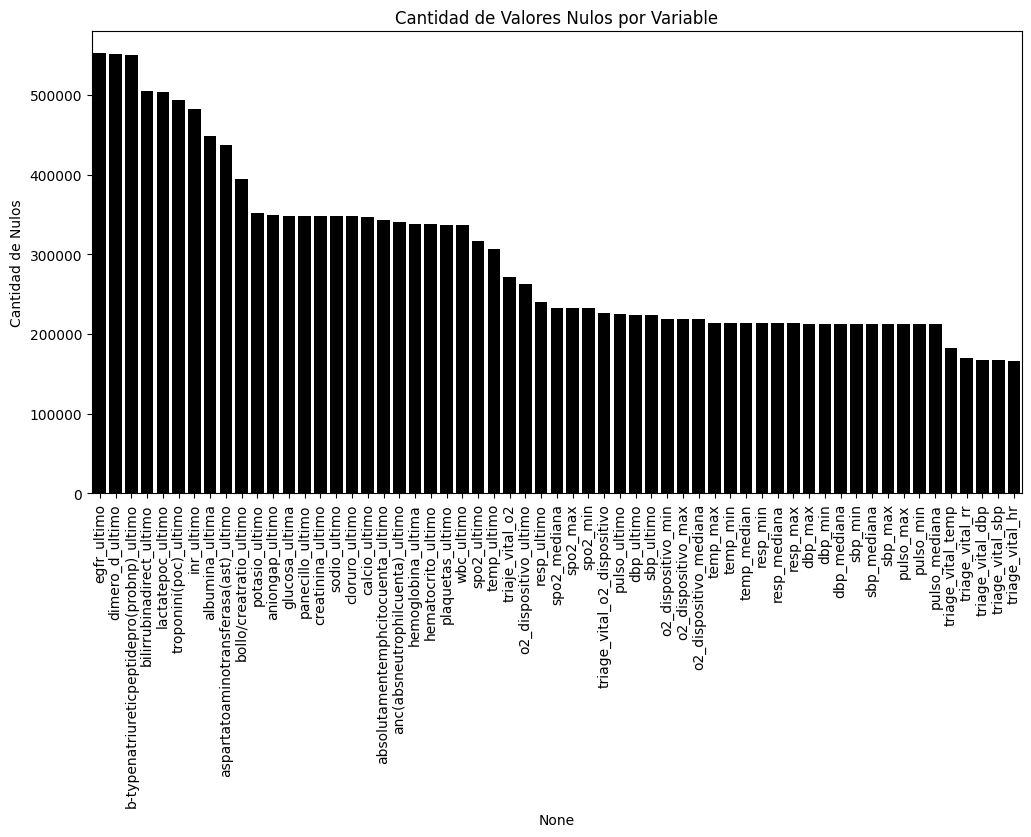

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

null_counts = df_triage_raw.isnull().sum()
null_percentage = (df_triage_raw.isnull().sum() / len(df_triage_raw)) * 100
null_df = pd.DataFrame({'Cantidad': null_counts, 'Porcentaje': null_percentage})
null_df = null_df[null_df['Cantidad'] > 0].sort_values(by='Cantidad', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=null_df.index, y=null_df['Cantidad'], color="black")
plt.xticks(rotation=90)
plt.ylabel("Cantidad de Nulos")
plt.title("Cantidad de Valores Nulos por Variable")
plt.show()


In [9]:
import pandas as pd

def remove_high_null_columns(df, threshold=50):
    """
    Elimina columnas con más del `threshold`% de valores nulos.

    Parámetros:
    - df: DataFrame de Pandas.
    - threshold: Umbral de porcentaje de nulos para eliminar la columna (default: 50%).

    Retorna:
    - df_cleaned: DataFrame sin las columnas con muchos nulos.
    - dropped_columns: Lista de columnas eliminadas.
    """
    # Calcular porcentaje de valores nulos por columna
    null_percentage = (df_triage_raw.isnull().sum() / len(df_triage_raw)) * 100
    
    # Filtrar columnas que tienen más del threshold% de nulos
    dropped_columns = null_percentage[null_percentage > threshold].index.tolist()
    
    # Eliminar esas columnas del DataFrame
    df_cleaned = df.drop(columns=dropped_columns)
    
    # Mostrar información
    print(f"Se eliminaron {len(dropped_columns)} columnas con más del {threshold}% de nulos.")
    print(f"Columnas eliminadas: {dropped_columns}")
    print(f"Nuevo tamaño del DataFrame: {df_cleaned.shape}")
    
    return df_cleaned, dropped_columns

# Aplicar la función al DataFrame `df_triage`
df_triage_cleaned, cols_removed = remove_high_null_columns(df_triage_raw)


Se eliminaron 26 columnas con más del 50% de nulos.
Columnas eliminadas: ['absolutamentemphcitocuenta_ultimo', 'albumina_ultima', 'anc(absneutrophilcuenta)_ultimo', 'aniongap_ultimo', 'aspartatoaminotransferasa(ast)_ultimo', 'b-typenatriureticpeptidepro(probnp)_ultimo', 'bilirrubinadirect_ultimo', 'panecillo_ultimo', 'bollo/creatratio_ultimo', 'calcio_ultimo', 'cloruro_ultimo', 'creatinina_ultimo', 'dimero_d_ultimo', 'egfr_ultimo', 'glucosa_ultima', 'hematocrito_ultimo', 'hemoglobina_ultima', 'inr_ultimo', 'lactatepoc_ultimo', 'plaquetas_ultimo', 'potasio_ultimo', 'sodio_ultimo', 'troponini(poc)_ultimo', 'wbc_ultimo', 'spo2_ultimo', 'temp_ultimo']
Nuevo tamaño del DataFrame: (560486, 517)


In [10]:
def analyze_and_fill_nulls(df, output_path):
    # Asegurarse de que la carpeta de salida exista
    if not os.path.exists(output_path):
        print(f"Error: La carpeta especificada no existe: {output_path}")
        return df

    # Análisis inicial de valores nulos
    na_report = pd.DataFrame({
        "Count": df.isnull().sum(),
        "Percentage": (df_triage_cleaned.isnull().sum() / len(df_triage_cleaned)) * 100
    })
    
    # Filtrar columnas con valores nulos
    na_report_with_nulls = na_report[na_report["Count"] > 0].sort_values(by="Count", ascending=False)
    
    # Guardar reporte inicial
    report_path = os.path.join(output_path, "reporte_valores_nulos_inicial.csv")
    na_report_with_nulls.to_csv(report_path)
    print(f"Reporte inicial de valores nulos guardado en: {report_path}")
    print("\nColumnas con valores nulos antes de rellenar:")
    print(na_report_with_nulls)
    
    # Obtener la lista de columnas con valores nulos para rellenar con la mediana
    columns_with_nulls = na_report_with_nulls.index.tolist()
    
    # Rellenar valores nulos con la mediana
    for col in columns_with_nulls:
        if df_triage_cleaned[col].isna().sum() > 0:
            median_value = df_triage_cleaned[col].median()
            df_triage_cleaned[col].fillna(median_value, inplace=True)
    
    # Verificación posterior al rellenado
    verification_report = pd.DataFrame({
        "Remaining_Nulls": df_triage_cleaned[columns_with_nulls].isnull().sum(),
        "Percentage": (df_triage_cleaned[columns_with_nulls].isnull().sum() / len(df_triage_cleaned)) * 100
    })
    
    # Guardar reporte de verificación
    verification_path = os.path.join(output_path, "reporte_verificacion_nulls.csv")
    verification_report.to_csv(verification_path)
    print(f"\nReporte de verificación guardado en: {verification_path}")
    print("\nValores nulos restantes después de rellenar con la mediana:")
    print(verification_report)
    
    return df_triage_cleaned

# Aplicar a df_triage
df_triage = analyze_and_fill_nulls(df_triage_cleaned, output_path=outputs_path)

Reporte inicial de valores nulos guardado en: c:\Users\Administrador\Documents\PythonScripts\Tesis\tesisaustral\outputs\descriptive_analysis\reporte_valores_nulos_inicial.csv

Columnas con valores nulos antes de rellenar:
                              Count  Percentage
triaje_vital_o2              271317   48.407454
o2_dispositivo_ultimo        262428   46.821508
resp_ultimo                  240014   42.822479
spo2_mediana                 232899   41.553045
spo2_max                     232899   41.553045
spo2_min                     232899   41.553045
triage_vital_o2_dispositivo  226855   40.474695
pulso_ultimo                 225121   40.165321
dbp_ultimo                   224394   40.035612
sbp_ultimo                   224272   40.013845
o2_dispositivo_max           218444   38.974033
o2_dispositivo_min           218444   38.974033
o2_dispositivo_mediana       218444   38.974033
temp_min                     214260   38.227538
temp_median                  214260   38.227538
temp_max  

C:\Users\Administrador\AppData\Local\Temp\ipykernel_19944\2141924847.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_triage, x=column, palette='pastel', order=custom_order)


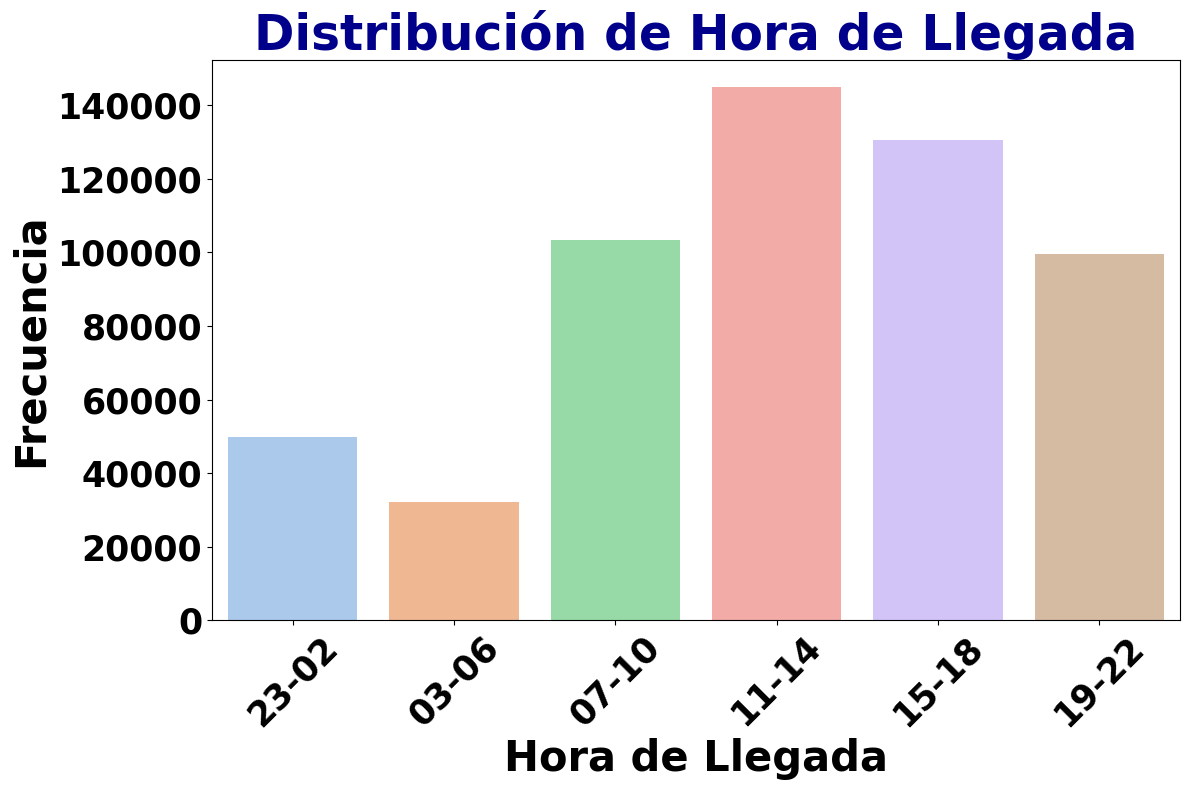

C:\Users\Administrador\AppData\Local\Temp\ipykernel_19944\2141924847.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_triage, x=column, palette='pastel')


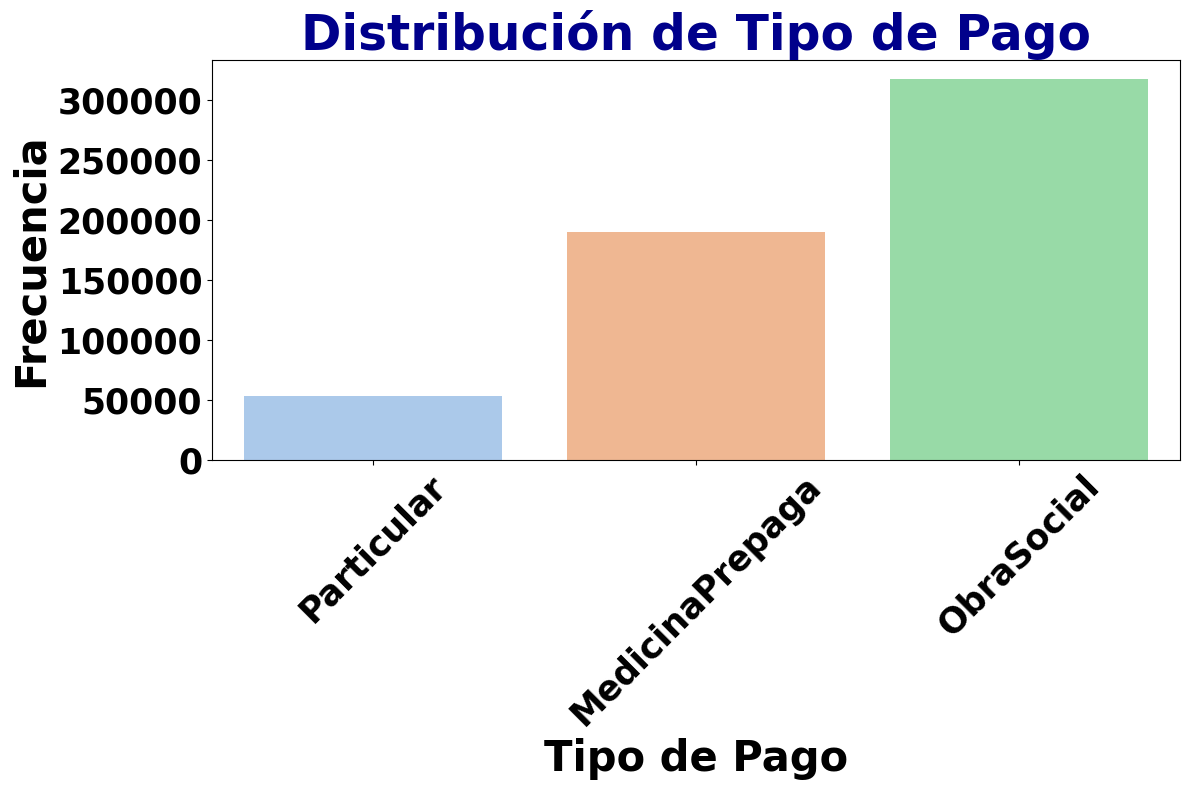

C:\Users\Administrador\AppData\Local\Temp\ipykernel_19944\2141924847.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_triage, x=column, palette='pastel')


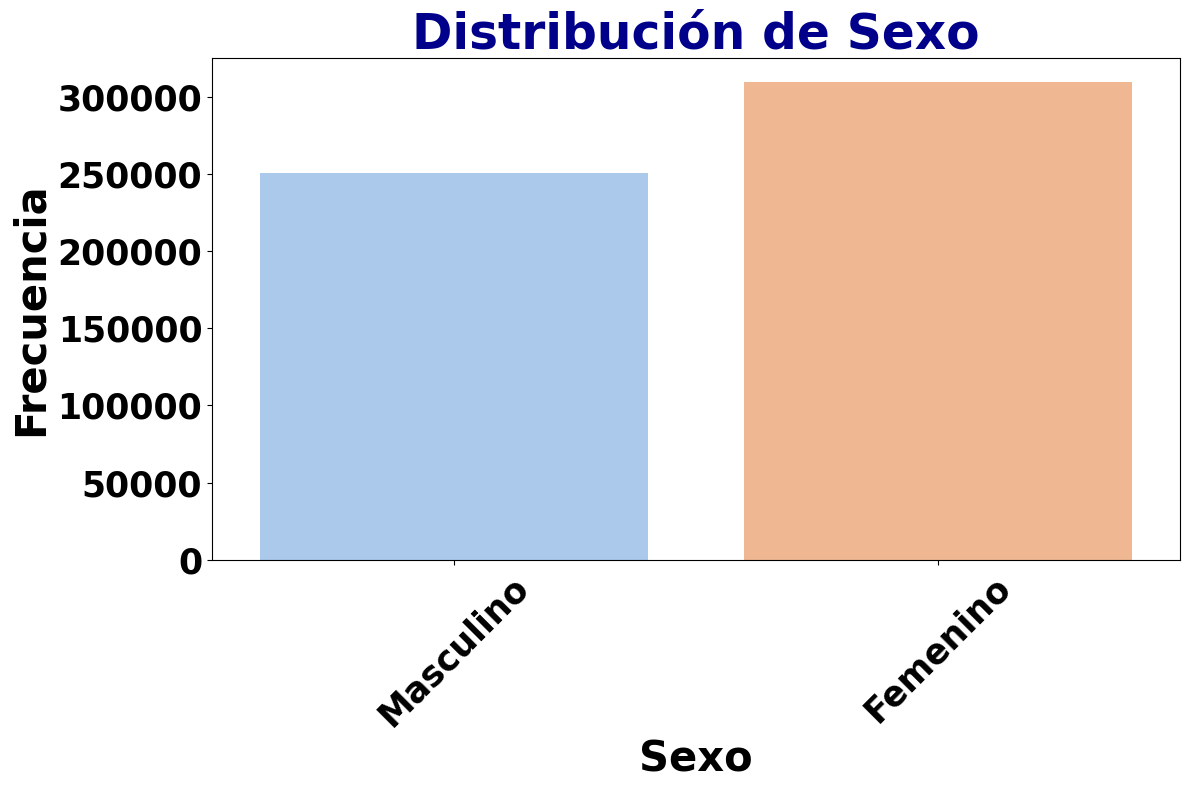

C:\Users\Administrador\AppData\Local\Temp\ipykernel_19944\2141924847.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_triage, x=column, palette='pastel', order=custom_order)


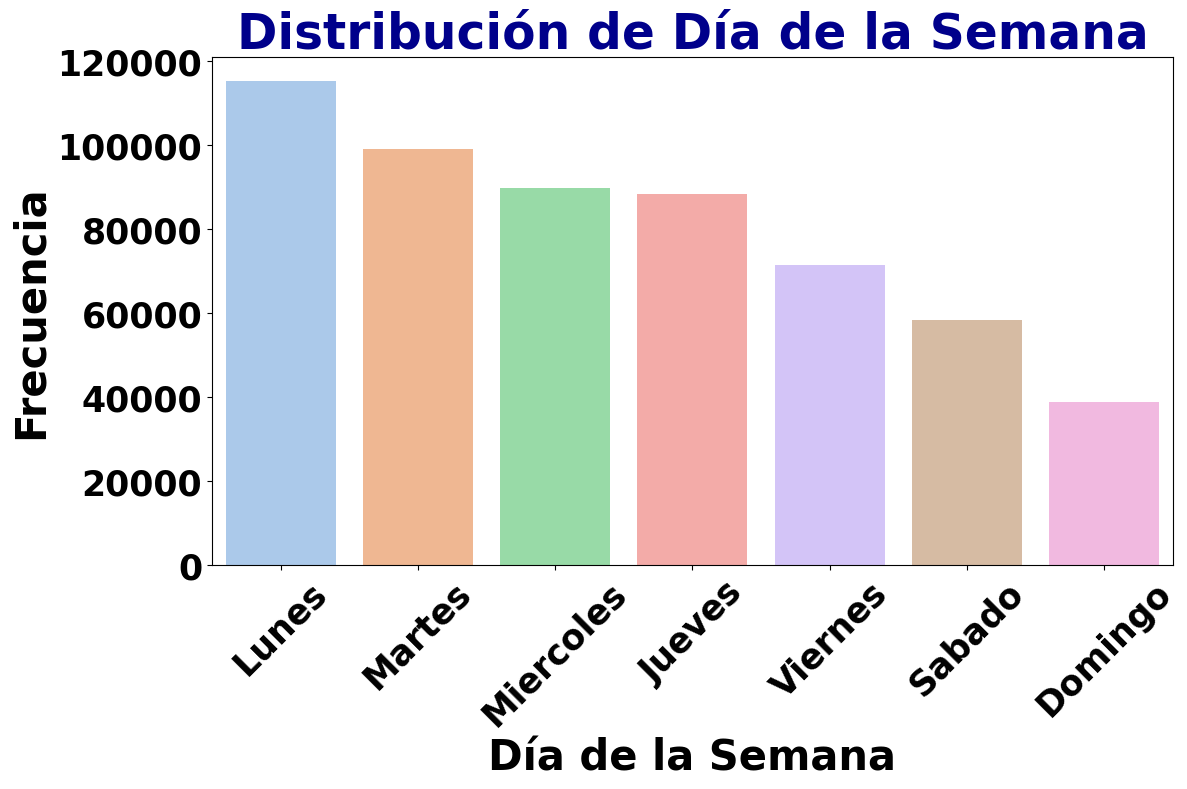

C:\Users\Administrador\AppData\Local\Temp\ipykernel_19944\2141924847.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_triage, x=column, palette='pastel')


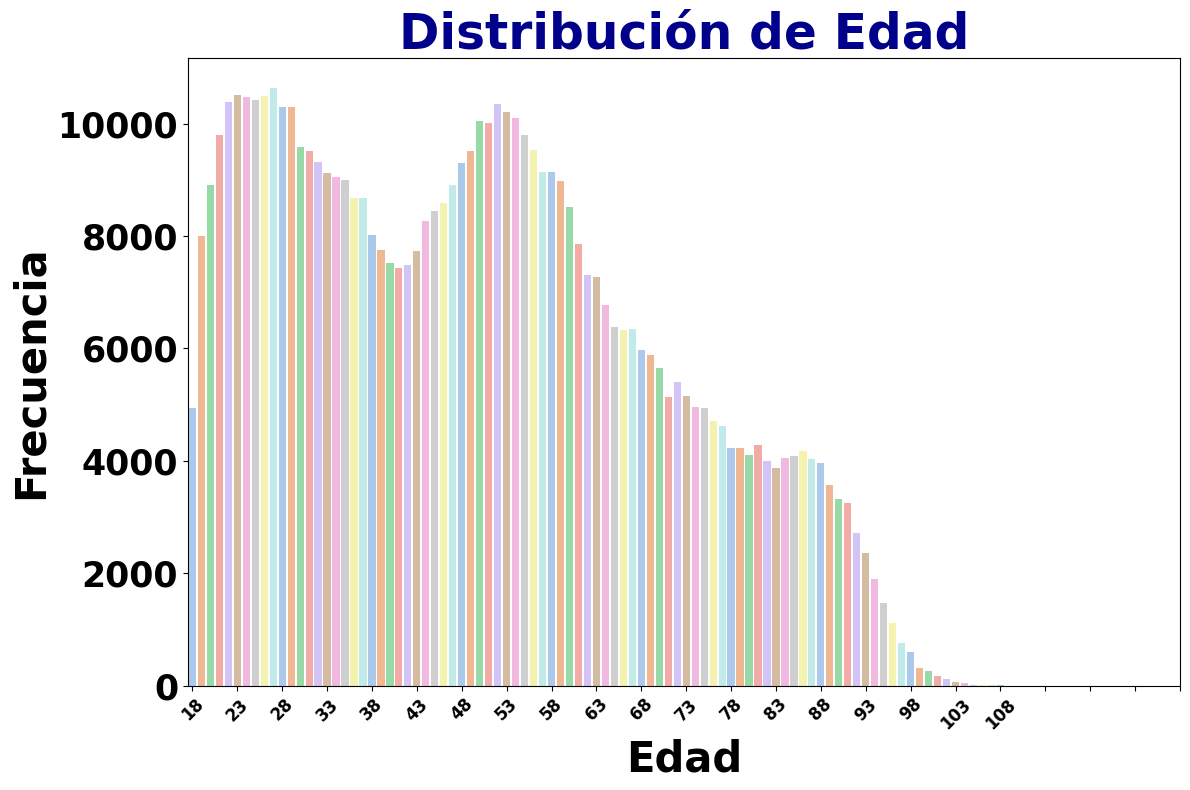

C:\Users\Administrador\AppData\Local\Temp\ipykernel_19944\2141924847.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_triage, x=column, palette='pastel', order=custom_order)


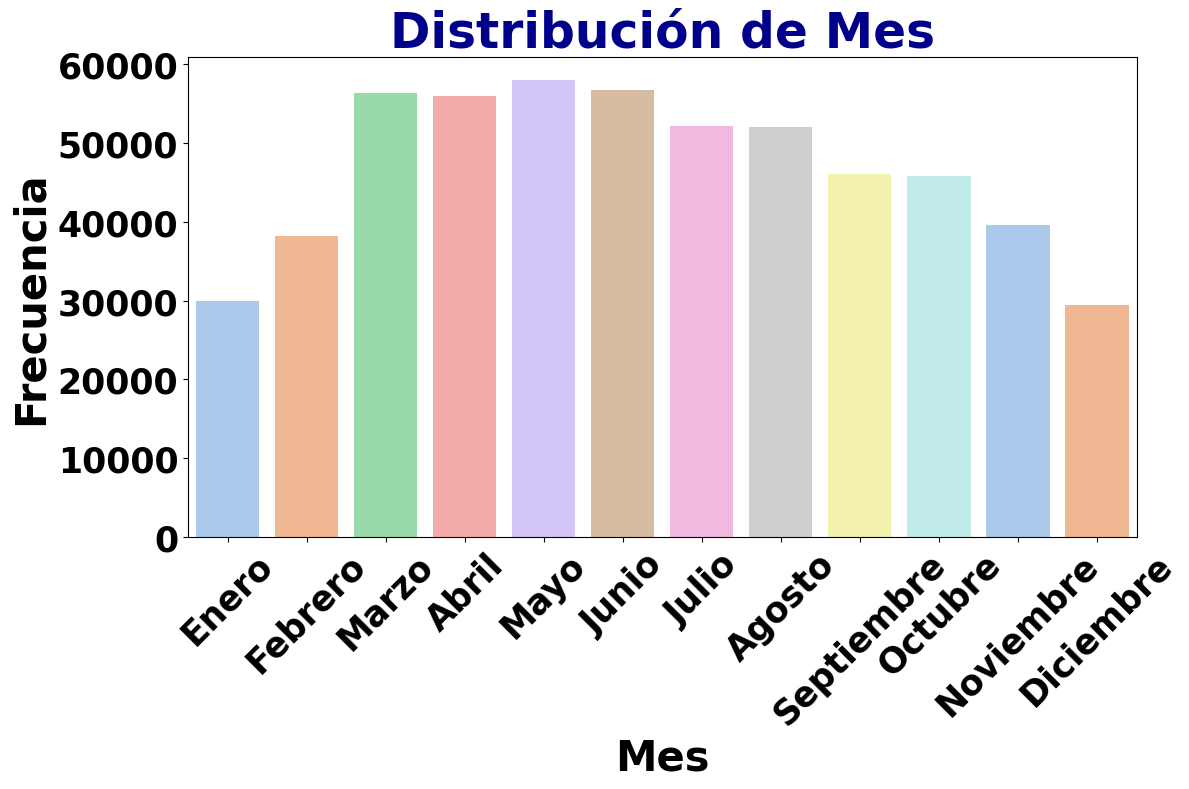

C:\Users\Administrador\AppData\Local\Temp\ipykernel_19944\2141924847.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_triage, x='sexo', y='edad', palette='pastel')


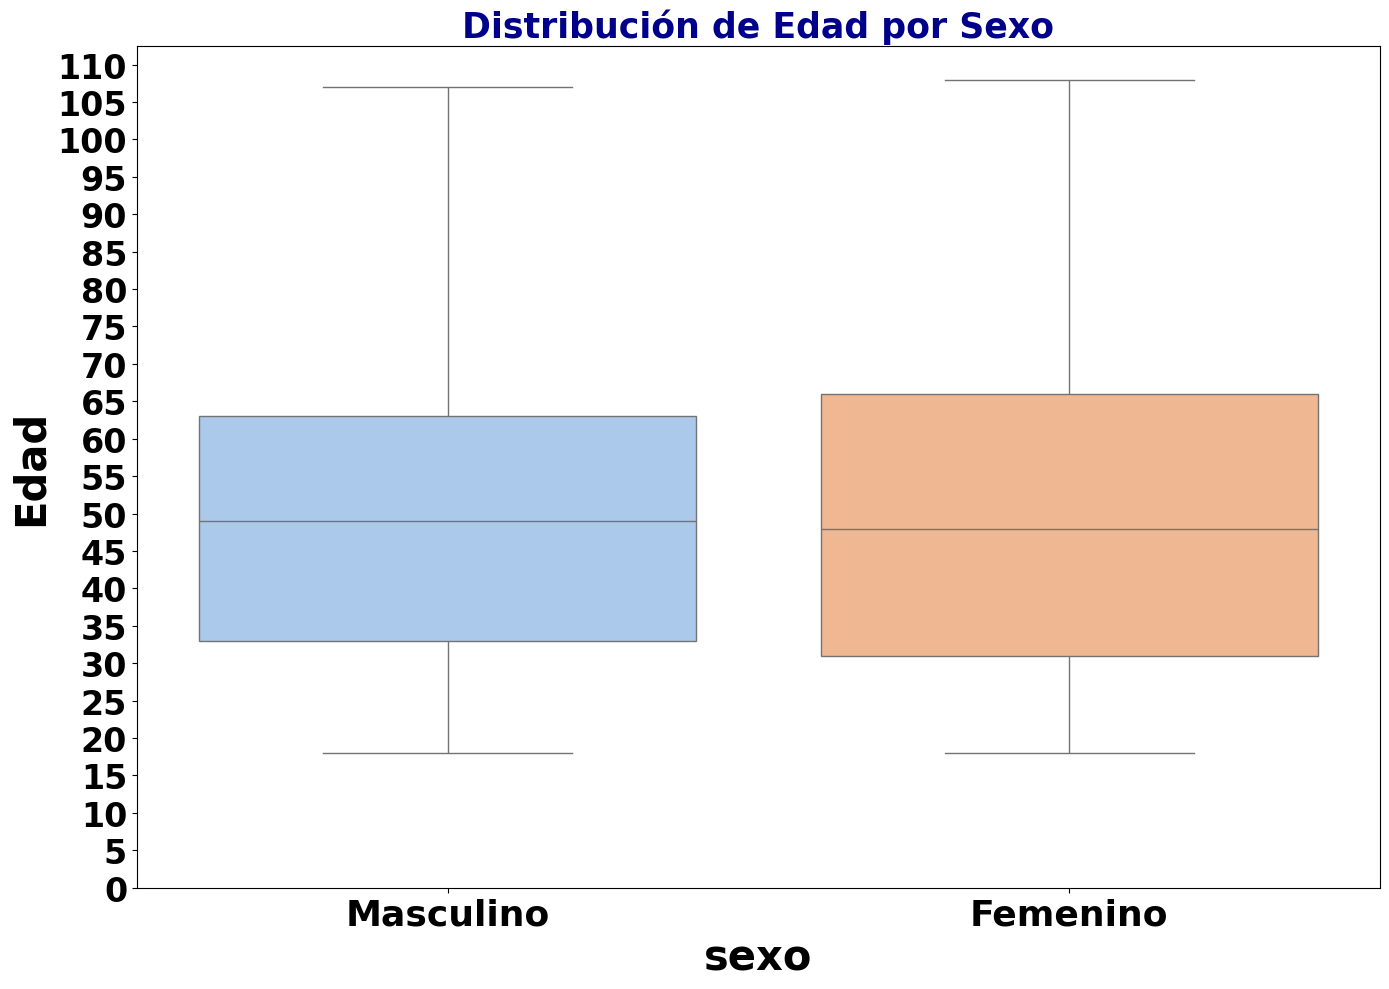

C:\Users\Administrador\AppData\Local\Temp\ipykernel_19944\2141924847.py:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_triage, x='modo_llegada', palette='pastel', order=modo_llegada_order)


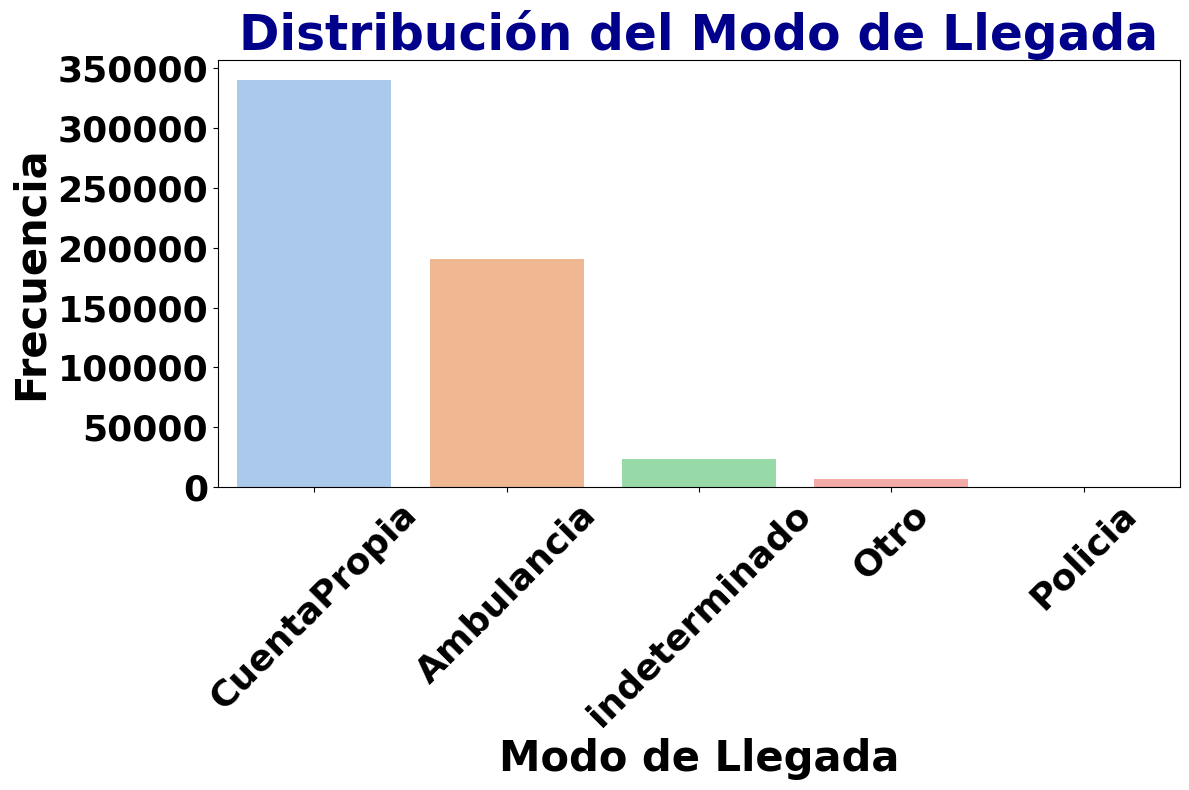

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Función para guardar y mostrar el gráfico
def save_and_show_plot(filename, path):
    plt.tight_layout()  # Ajusta el layout para evitar cortes
    plt.savefig(f"{path}/{filename}.png", dpi=300, bbox_inches='tight')  # Guarda el gráfico como imagen
    plt.show()  # Muestra el gráfico
    plt.close()  # Cierra la figura para liberar memoria

# Definir órdenes personalizados
hora_order = ['23-02', '03-06', '07-10', '11-14', '15-18', '19-22']  # Orden para 'llegada_hora_bin'
dia_order = ['Lunes', 'Martes', 'Miercoles', 'Jueves', 'Viernes', 'Sabado', 'Domingo']  # Orden para 'dia'
mes_order = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']  # Orden para 'mes'

# Convertir columnas a tipo categórico con órdenes personalizados
df_triage['llegada_hora_bin'] = pd.Categorical(df_triage['llegada_hora_bin'], categories=hora_order, ordered=True)
df_triage['dia'] = pd.Categorical(df_triage['dia'], categories=dia_order, ordered=True)
df_triage['mes'] = pd.Categorical(df_triage['mes'], categories=mes_order, ordered=True)

# Lista de columnas, títulos y órdenes personalizados (si aplica)
columns_and_titles = [
    ('llegada_hora_bin', 'Hora de Llegada', hora_order),
    ('TipoCobertura', 'Tipo de Pago', None),  # Sin orden personalizado
    ('sexo', 'Sexo', None),  # Sin orden personalizado
    ('dia', 'Día de la Semana', dia_order),  # Con orden personalizado
    ('edad', 'Edad', None),  # Nueva columna para edad
    ('mes', 'Mes', mes_order)  # Distribución por Mes
]

# Generar gráficos para cada columna
for column, title, custom_order in columns_and_titles:
    # Crear el gráfico
    plt.figure(figsize=(12, 8))  # Aumentar el tamaño del gráfico

    # Si hay un orden personalizado, usarlo
    if custom_order:
        sns.countplot(data=df_triage, x=column, palette='pastel', order=custom_order)
    else:
        sns.countplot(data=df_triage, x=column, palette='pastel')

    # Personalización del gráfico
    plt.title(f'Distribución de {title}', fontsize=35, weight='bold', color='darkblue')  # Título más grande y en negrita
    plt.xlabel(title, fontsize=30, weight='bold')  # Etiqueta del eje X más grande y en negrita
    plt.ylabel('Frecuencia', fontsize=30, weight='bold')  # Etiqueta del eje Y más grande y en negrita
    plt.xticks(rotation=45, fontsize=25, weight='bold')  # Etiquetas del eje X más grandes y rotadas
    plt.yticks(fontsize=25, weight='bold')  # Etiquetas del eje Y más grandes

    # Ajustar etiquetas del eje X para la distribución de la edad
    if column == 'edad':
        plt.xticks(ticks=range(0, df_triage['edad'].max() + 5, 5), fontsize=12, weight='bold')  # Etiquetas cada 5 años

    # Guardar y mostrar el gráfico
    save_and_show_plot(column.lower(), outputs_path)

# Gráfico combinado de género y edad
plt.figure(figsize=(14, 10))
sns.boxplot(data=df_triage, x='sexo', y='edad', palette='pastel')

# Personalización del gráfico combinado
plt.title('Distribución de Edad por Sexo', fontsize=25, weight='bold', color='darkblue')
plt.xlabel('sexo', fontsize=30, weight='bold')
plt.ylabel('Edad', fontsize=30, weight='bold')
plt.xticks(fontsize=26, weight='bold')
plt.yticks(ticks=range(0, df_triage['edad'].max() + 5, 5), fontsize=24, weight='bold')  # Etiquetas del eje Y cada 5 años

# Guardar y mostrar el gráfico combinado
save_and_show_plot('genero_edad_combinado', outputs_path)

# Distribución del Modo de Llegada ordenado de mayor a menor
plt.figure(figsize=(12, 8))
modo_llegada_order = df_triage['modo_llegada'].value_counts().index  # Orden decreciente por conteo
sns.countplot(data=df_triage, x='modo_llegada', palette='pastel', order=modo_llegada_order)

plt.title('Distribución del Modo de Llegada', fontsize=35, weight='bold', color='darkblue')
plt.xlabel('Modo de Llegada', fontsize=30, weight='bold')
plt.ylabel('Frecuencia', fontsize=30, weight='bold')
plt.xticks(rotation=45, fontsize=26, weight='bold')
plt.yticks(fontsize=26, weight='bold')

# Guardar y mostrar el gráfico
save_and_show_plot('modo_llegada', outputs_path)




Analizando la distribución de clases de la variable target...

Distribución de clases:
nivel_triage
5    155452
4    125201
3    119213
2    108742
1     51878
Name: count, dtype: int64

Razón de clase mayoritaria a clase minoritaria: 3.00


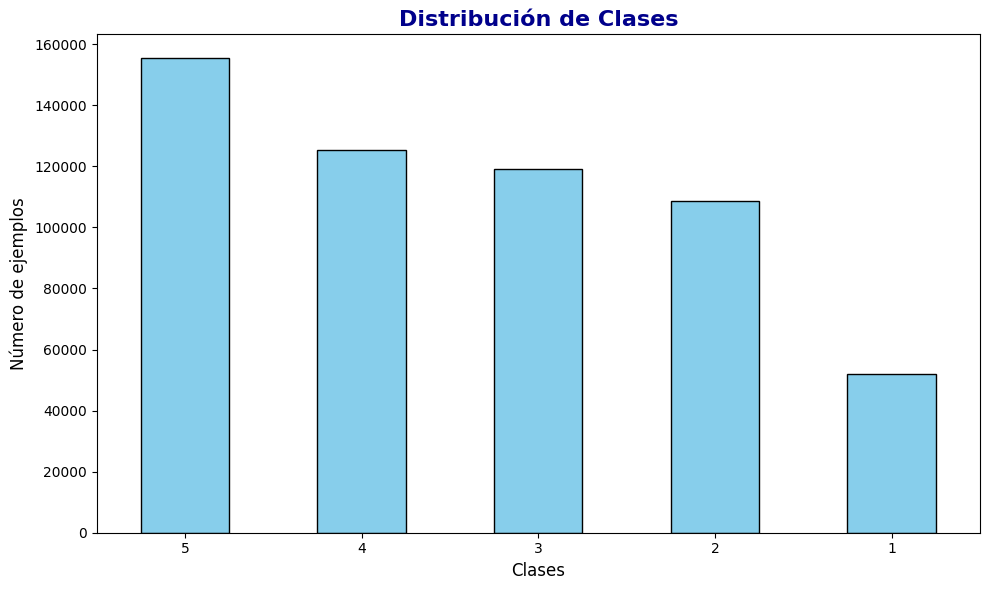

In [12]:
#analisis clase
# Función para guardar y mostrar el gráfico
def save_and_show_plot(filename, path):
    """
    Guarda el gráfico como una imagen y lo muestra.
    """
    plt.tight_layout()  # Ajusta el layout para evitar cortes
    plt.savefig(f"{path}/{filename}.png", dpi=300, bbox_inches='tight')  # Guarda el gráfico como imagen
    plt.show()  # Muestra el gráfico
    plt.close()  # Cierra la figura para liberar memoria

# Función para analizar la distribución de clases de la variable target
def analyze_target_class_distribution(df, target_col, outputs_path):
    print("\nAnalizando la distribución de clases de la variable target...")

    # Verificar la distribución de clases
    class_distribution = df[target_col].value_counts()

    # Imprimir la distribución de clases
    print("\nDistribución de clases:")
    print(class_distribution)

    # Calcular la razón de clase mayoritaria a clase minoritaria
    class_ratio = class_distribution.max() / class_distribution.min()
    print(f"\nRazón de clase mayoritaria a clase minoritaria: {class_ratio:.2f}")

    # Visualizar la distribución de clases
    plt.figure(figsize=(10, 6))
    class_distribution.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title('Distribución de Clases', fontsize=16, weight='bold', color='darkblue')
    plt.xlabel('Clases', fontsize=12)
    plt.ylabel('Número de ejemplos', fontsize=12)
    plt.xticks(rotation=0)
    plt.tight_layout()

    # Guardar y mostrar el gráfico
    save_and_show_plot("class_distribution", outputs_path)

# Llamada a la función (ejemplo)
analyze_target_class_distribution(df_triage, 'nivel_triage', outputs_path)


In [13]:
#columnas dolencias
dolencias = ['cc_abdominalcramping','cc_distension_abdominal','cc_dolorabdominal','cc_dolorabdominalembarazada','cc_abnormallab','cc_absceso','problema_de_adiccion_cc','cc_agitacion','cc_alcoholintoxicacion','cc_problemaalcohol','cc_reaccionalergica','cc_alteredmentalstatus','cc_animalbite','cc_lesiondetobillo','cc_dolor_tobillo','cc_ansiedad','cc_lesion_brazo','cc_dolor_brazo','cc_hinchazon_brazo','cc_victima_agresion','cc_asma','cc_dolor_espalda','cc_sangrado_moretones','cc_borrosavision','cc_exposicion_fluidos_corporales','cc_dolor_de_pecho','cc_dificultad_respiratoria','cc_problema_de_respiracion','cc_quemadura','cc_paro_cardiaco','cc_celulitis','cc_dolor_pecho','cc_opresion_pecho','cc_escalofrios','cc_resfrio','cc_confusion','cc_conjuntivitis','cc_estrenimiento','cc_tos','cc_quiste','cc_disminucion_del_azucar_en_la_sangre-sintomatico','cc_deshidratacion','cc_dolor_dental','cc_depresion','cc_desintoxicacion','cc_diarrea','cc_mareos','cc_evaluacion_adiccion','cc_problemadedrogas','cc_disnea','cc_disuria','cc_dolor_oido','problema_cc_oido','cc_edema','cc_dolor_codo','cc_azucar_sangre_asintomatico','cc_azucar_sangre_sintomatico','cc_emesis','cc_dolorepigastrico','cc_epistaxis','cc_exposicion_ETS','cc_laceracion_extremidad','cc_extremidaddebilidad','cc_lesion_ocular','cc_dolor_ojos','cc_problema_ocular','cc_enrojecimiento_ojos','cc_lesion_facial','cc_laceracion_facial','cc_dolor_facial','cc_hinchazon_facial','cc_caida','cc_caida_mas_65','cc_fatiga','cc_problema_femenino','fiebre_cc','cc_fiebre_mas_75','cc_fiebre_9a74','cc_fiebre_inmunodepresion','cc_lesiondedos','cc_dolordedos','cc_hinchazon_dedos','cc_dolor_flanco','cc_seguimiento-celulitis','cc_injuriadelpie','cc_dolor_pie','cc_hinchazon_pie','cc_cuerpo_extraño_en_ojo','cc_trauma_total','cc_dolores_generalizados','cc_sangrado_gastrico','problema_cc_gi','cc_dolor_ingle','cc_alucinaciones','cc_lesion_mano','cc_dolor_mano','dolor_de_cabeza_cc','cc_dolor_cabeza_nuevos_sintomas','cc_dolor_cabeza_recurrente','cc_dolor_cabeza_evaluacion','cc_lesion_cabeza','cc_laceracion_cabeza','cc_hematuria','cc_hemoptisis','cc_dolor_cadera','cc_homicida','cc_hiperglucemia','cc_hipertension','cc_hipotension','cc_influenza','cc_ingestion','cc_picadura_insecto','cc_latidoirregular','cc_dolor_mandibula','cc_hinchazon_de_las_articulaciones','cc_lesionderodilla','cc_rodilla','cc_laceracion','cc_lesion_pierna','cc_dolor_pierna','cc_hinchazon_pierna','cc_letargo','cc_perdida_conocimiento','cc_maleguproblema','cc_masa','cc_problemamedico','cc_examen_medico','cc_problemademedicamento','cc_recargademedicamento','cc_migrana','cc_modificadotrauma','cc_accidente_automovilistico','cc_maccidente_motocicleta','cc_caidas_multiples','cc_congestion_nasal','cc_nauseas','cc_sincope','cc_dolor_cuello','cc_problemaneurologico','cc_entumecimiento','cc_hinchazon_bucal','cc_otalgia','cc_otro','cc_sobredosis-accidental','cc_sobredosis-intencional','cc_dolor','cc_palpitaciones','cc_ataque_panico','cc_dolor_pelvico','envenenamiento_cc','cc_post-opproblema','cc_evaluacion_psiquitatrica','sintomas_psicoticos','cc_erupcion','cc_sangradorectal','cc_dolor_rectal','cc_distressrespiratorio','cc_lesion_costillas','cc_dolor_costillas','cc_convulsiones_nuevo','cc_convulciones_antecedentes','cc_convulsiones','cc_falta_de_aliento','cc_lesiondehombro','cc_dolor_de_hombro','cc_dolor_celulas_falciformes','problema_cc_sinusal','cc_irritacionde_la_piel','cc_problema_piel','cc_dolor_de_garganta','cc_control_estandar','cc_alerta_ACV','cc_suicida','cc_retiro_sutura','cc_cuerpo_extraño_ingerido','cc_sincope','cc_testiclepain','cc_thumbinjury','cc_tickremoval','cc_toeinjury','cc_toepain','cc_trauma','cc_unresponsive','cc_uri','cc_frecuenciaurinaria','cc_retencionurinaria','cc_infeccion_del_tracto_urinario','cc_sangradovaginal','cc_descargavaginal','cc_dolor_vaginal','cc_debilidad','cc_sibilancias','cc_retiro-alcohol','cc_verificacion_de_heridas','cc_infeccion_de_heridas','cc_evaluacion-herida','cc_lesiondemuneca','cc_dolor_de_muneca']


Calculando la frecuencia de dolencias...

Frecuencia de dolencias calculada:
cc_dolorabdominal      54345
cc_otro                51025
cc_dolor_pecho         35798
cc_falta_de_aliento    24666
cc_dolor_espalda       20643
                       ...  
cc_sangradorectal        233
cc_celulitis             205
cc_convulsiones          170
cc_hiperglucemia         110
cc_ingestion              94
Length: 198, dtype: int64

Top 25 dolencias más frecuentes:
cc_dolorabdominal                  54345
cc_otro                            51025
cc_dolor_pecho                     35798
cc_falta_de_aliento                24666
cc_dolor_espalda                   20643
cc_caida                           19026
cc_alcoholintoxicacion             15939
cc_maccidente_motocicleta          14891
cc_mareos                          12789
cc_tos                             12556
cc_emesis                          11516
cc_dolor_pierna                     9923
cc_dolor_flanco                     8927
cc_dolor_c

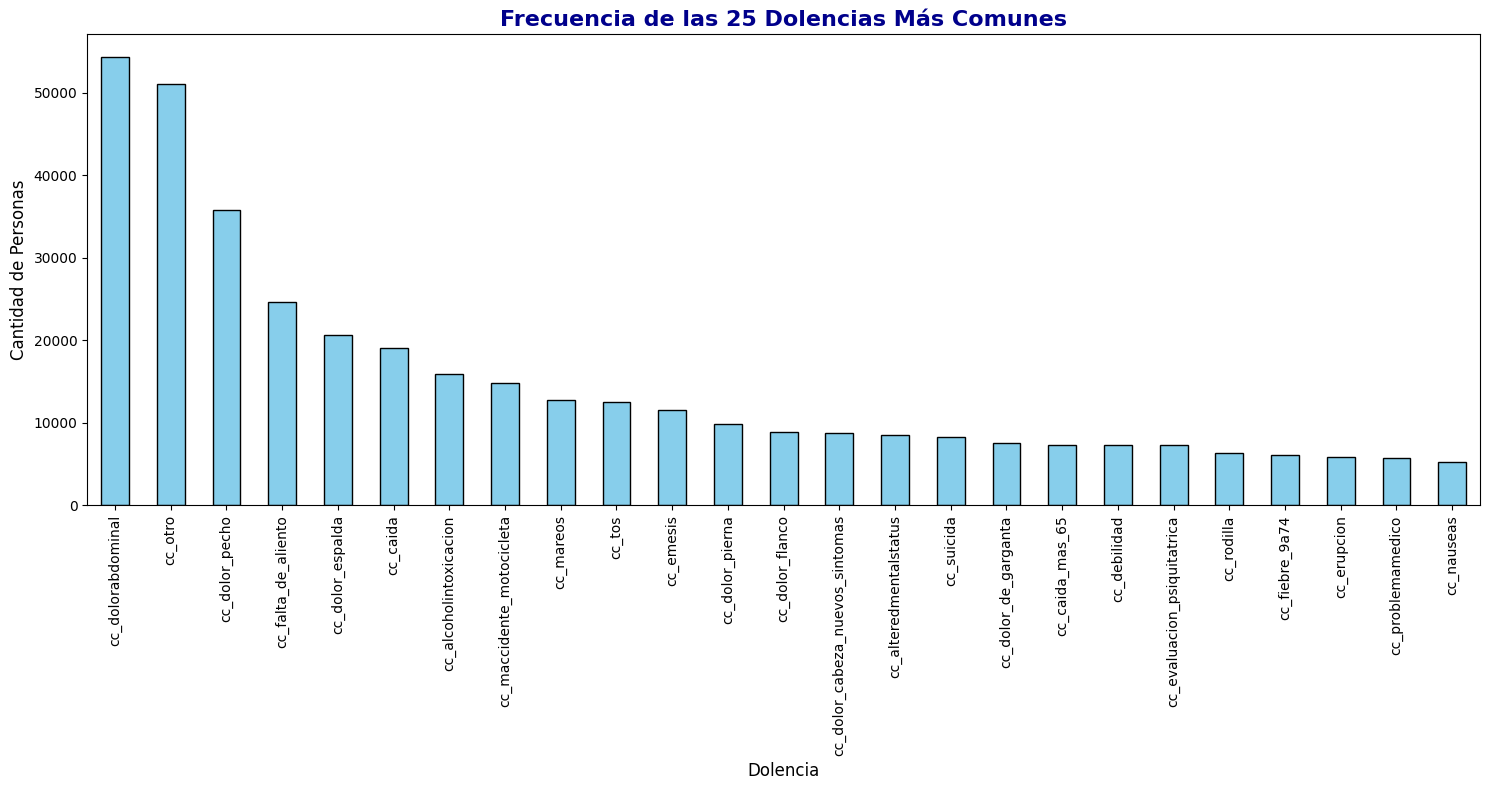

In [14]:
# Función para guardar y mostrar el gráfico
def save_and_show_plot(filename, path):
    """
    Guarda el gráfico como una imagen y lo muestra.
    """
    plt.tight_layout()  # Ajusta el layout para evitar cortes
    plt.savefig(f"{path}/{filename}.png", dpi=300, bbox_inches='tight')  # Guarda el gráfico como imagen
    plt.show()  # Muestra el gráfico
    plt.close()  # Cierra la figura para liberar memoria

# Función para analizar las dolencias más frecuentes
def analyze_top_dolencias(df, dolencias, outputs_path):
    print("\nCalculando la frecuencia de dolencias...")

    # Calcular la suma de cada columna booleana para obtener la cantidad de personas con cada dolencia
    dolencia_counts = df[dolencias].sum().sort_values(ascending=False)

    print("\nFrecuencia de dolencias calculada:")
    print(dolencia_counts)

    # Seleccionar las 25 dolencias más frecuentes
    top_25_dolencias = dolencia_counts.head(25)
    print("\nTop 25 dolencias más frecuentes:")
    print(top_25_dolencias)

    # Graficar el histograma
    plt.figure(figsize=(15, 8))
    top_25_dolencias.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title('Frecuencia de las 25 Dolencias Más Comunes', fontsize=16, weight='bold', color='darkblue')
    plt.xlabel('Dolencia', fontsize=12)
    plt.ylabel('Cantidad de Personas', fontsize=12)
    plt.xticks(rotation=90, ha='center', fontsize=10)
    plt.tight_layout()  # Ajustar el layout para que las etiquetas no se corten

    # Guardar y mostrar el gráfico
    save_and_show_plot("top_25_dolencias", outputs_path)

# Llamada a la función (ejemplo)
analyze_top_dolencias(df_triage, dolencias, outputs_path)


In [15]:
    campos_outliers = ['triage_vital_hr','triage_vital_sbp','triage_vital_dbp','triage_vital_rr','triaje_vital_o2','triage_vital_temp','n_visita_urgencia','n_admisiones','n_cirugias','med_combinacion_analgesica_y_antihistaminica','med_analgesicos','med_anestesicos','med_anti-obesidad','med_antialergia','med_antiartriticos','med_antiasma','med_antibioticos','med_anticoagulantes','med_antidotos','med_antifungicos','med_combinacion_de_antihistaminico_y_descongestionante','med_antihistaminicos','med_antihiperglucemicos','med_antiinfecciosos','med_antiinfectives/varios','med_antineopultimoics','med_antiparkinsondrogas','med_antiplaquetarios','med_antivirales','med_autonomas','med_cardiacos','med_cardiovasculares','med_cns','med_anticonceptivos','med_diureticos','med_gastrointestinales','med_inmunosupresores','med_investigacional','med_relajantes_musculares','med_pre-natalvitaminas','med_psicoterapeuticos','med_sedantes/hipnoticos','med_vitaminas','cxr_cuenta','cuenta_echo','recuento_electrocardiograma','headct_cuenta','mri_cuenta','otroct_cuenta','otroimg_cuenta','otrosus_cuenta','otroxr_cuenta','edad','pulso_ultimo','resp_ultimo','spo2_ultimo','temp_ultimo','sbp_ultimo','dbp_ultimo','pulso_min','resp_min','spo2_min','temp_min','sbp_min','dbp_min','pulso_max','resp_max','spo2_max','temp_max','sbp_max','dbp_max','pulso_mediana','resp_mediana','spo2_mediana','sbp_mediana','dbp_mediana','cuenta_sangre','glucosaua_cuenta','leucocitosua_cuenta','nitriteua_cuenta','proteinua_cuenta','bloodcultureroutine_cuenta','urinecultureroutine_cuenta','absolutamentemphcitocuenta_ultimo','albumina_ultima','anc(absneutrophilcuenta)_ultimo','aniongap_ultimo','aspartatoaminotransferasa(ast)_ultimo','b-typenatriureticpeptidepro(probnp)_ultimo','bilirrubinadirect_ultimo','panecillo_ultimo','bollo/creatratio_ultimo','calcio_ultimo','cloruro_ultimo','creatinina_ultimo','dimero_d_ultimo','egfr_ultimo','glucosa_ultima','hematocrito_ultimo','hemoglobina_ultima','inr_ultimo','lactatepoc_ultimo','plaquetas_ultimo','potasio_ultimo','sodio_ultimo','troponini(poc)_ultimo','wbc_ultimo']
    #campos_a_analizar = df_triage_campos_outliers 
    
    # Restar los campos eliminados de la lista de campos_outliers
    campos_outliers_filtrados = [campo for campo in campos_outliers if campo not in cols_removed]
     
    # Aplicar Isolation Forest
    iso_forest = IsolationForest(n_estimators=100, max_samples='auto', contamination='auto', random_state=42)
    df_triage['outliers'] = iso_forest.fit_predict(df_triage[campos_outliers_filtrados])

    # Filtrar los outliers detectados
    outliers = df_triage[df_triage['outliers'] == -1]

    # Calcular el porcentaje de outliers
    total_rows = len(df_triage)
    num_outliers = len(outliers)
    percentage_outliers = (num_outliers / total_rows) * 100

    # Mostrar resultados
    print(f"Total de datos: {total_rows}")
    print(f"Número de outliers detectados: {num_outliers}")
    print(f"Porcentaje de outliers: {percentage_outliers:.2f}%")

    # Interpretación de los resultados
    threshold = 5  # Umbral del 5% por ejemplo

    if percentage_outliers > threshold:
        print("El porcentaje de outliers es alto, lo que podría indicar que los datos están distorsionados.")
    else:
        print("El porcentaje de outliers es bajo, probablemente no afecta significativamente el análisis.")

Total de datos: 560486
Número de outliers detectados: 15451
Porcentaje de outliers: 2.76%
El porcentaje de outliers es bajo, probablemente no afecta significativamente el análisis.


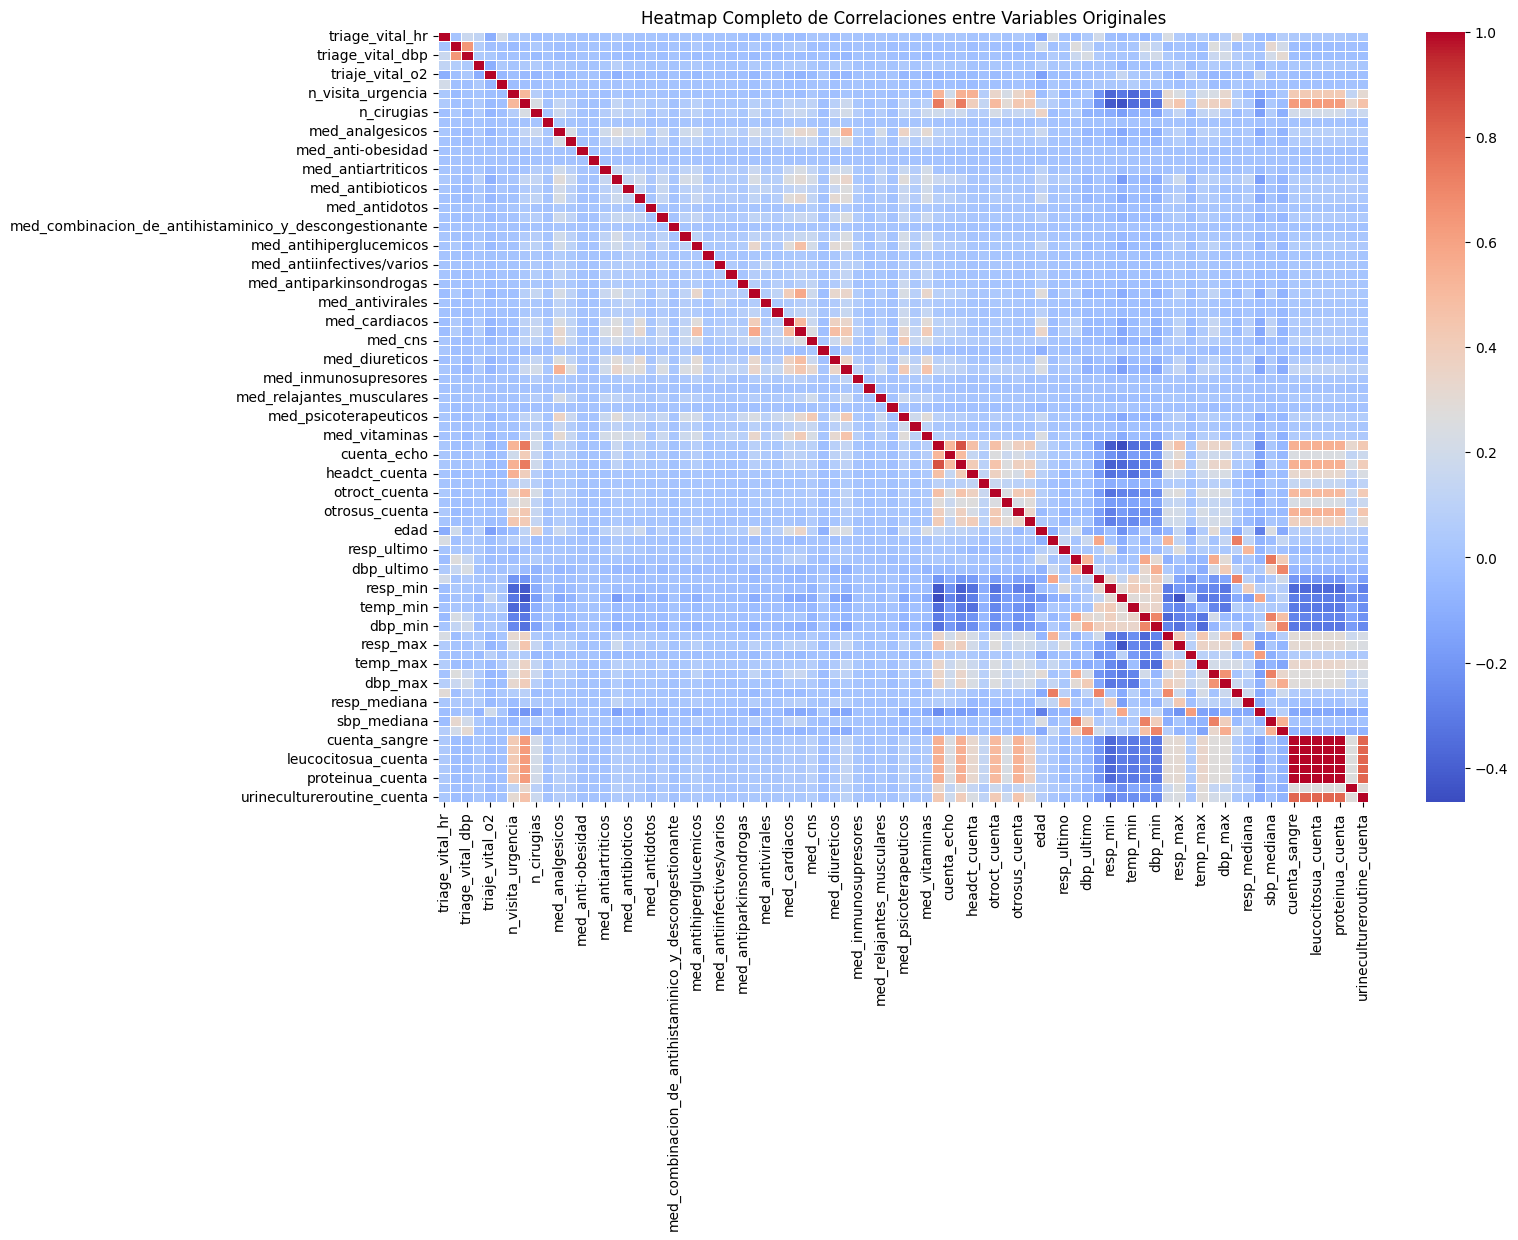

In [17]:
# 1. Calcular la matriz de correlación de las variables originales
correlation_matrix_original = df_triage[campos_outliers_filtrados].corr()

# 2. Visualizar usando un heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix_original, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap Completo de Correlaciones entre Variables Originales')

# Guardar la figura en un archivo (por ejemplo, en formato PNG)
ruta_completa = os.path.join(outputs_path, 'heatmap_correlacion.png')  # Combina la ruta y el nombre del archivo
plt.savefig(ruta_completa, bbox_inches='tight')

# Mostrar el gráfico en pantalla
plt.show()

In [18]:
import os
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
from sklearn.preprocessing import OneHotEncoder

print("\nRealizando codificación one-hot...")

# Convertir todas las columnas de tipo entero a int32
for col in df_triage.select_dtypes(include=['int64', 'int']).columns:
    df_triage[col] = df_triage[col].astype(np.int32)

categorical_columns = ['modo_llegada', 'mes', 'dia', 'llegada_hora_bin', 'TipoCobertura', 'sexo']
one_hot_params = config["parameters"]["01_LecturayAnalisis"]["one_hot_encoder"]
encoder = OneHotEncoder(**one_hot_params)

# 🚀 Aplicar One-Hot Encoding
encoded_columns = encoder.fit_transform(df_triage[categorical_columns])

# 🔥 CORRECCIÓN: No usar .toarray(), ya que ya es un numpy array
encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(categorical_columns))

# Concatenar el dataframe original sin las columnas categóricas y el dataframe codificado
df_triage_encoded = pd.concat([df_triage.drop(columns=categorical_columns), encoded_df], axis=1)

# 🚀 Eliminar cualquier columna de índice antes de guardar
if "Unnamed: 0" in df_triage_encoded.columns:
    df_triage_encoded = df_triage_encoded.drop(columns=["Unnamed: 0"])

# Asegurar que no haya índice oculto
df_triage_encoded = df_triage_encoded.reset_index(drop=True)

# Generar reporte de columnas
columns_report = []
for col in df_triage_encoded.columns:
    column_info = {
        'nombre_columna': col,
        'tipo_dato': str(df_triage_encoded[col].dtype),
        'es_categorica': 'Sí' if col in encoder.get_feature_names_out(categorical_columns) else 'No',
        'columna_original': next((cat for cat in categorical_columns if cat in col), 'N/A'),
        'valores_unicos': len(df_triage_encoded[col].unique()),
        'nulos': df_triage_encoded[col].isnull().sum(),
        'porcentaje_nulos': f"{(df_triage_encoded[col].isnull().sum() / len(df_triage_encoded)) * 100:.2f}%"
    }
    columns_report.append(column_info)

# Crear DataFrame del reporte y guardarlo
report_df = pd.DataFrame(columns_report)
report_path = os.path.join(os.path.dirname(outputs_path), "reporte_columnas.csv")
report_df.to_csv(report_path, index=False)

# Guardar en formato Parquet sin índice
output_file = os.path.join(parquet_path, "df_triage_encoded.parquet")
metadata = {
    "original_file": dataset_file,
    "categorical_columns": ",".join(categorical_columns)
}

# 🚀 Conversión a Parquet sin índice
parquet_table = pa.Table.from_pandas(df_triage_encoded, preserve_index=False)

# Añadir metadatos personalizados
parquet_table = parquet_table.replace_schema_metadata({
    **(parquet_table.schema.metadata or {}), 
    **{key.encode(): value.encode() for key, value in metadata.items()}
})

# Escribir archivo Parquet
pq.write_table(parquet_table, output_file)

print(f"\nDataset procesado guardado en: {output_file}")
print(f"Reporte de columnas guardado en: {report_path}")
print(f"Dimensiones finales del dataset: {df_triage_encoded.shape}")



Realizando codificación one-hot...

Dataset procesado guardado en: c:\Users\Administrador\Documents\PythonScripts\Tesis\tesisaustral\intermediate/encoded\df_triage_encoded.parquet
Reporte de columnas guardado en: c:\Users\Administrador\Documents\PythonScripts\Tesis\tesisaustral\outputs\reporte_columnas.csv
Dimensiones finales del dataset: (560486, 540)
